In [1]:
# COMP5339 Week 10 Tutorial
# Material last updated: 31 March 2025
# Note materials were designed with the Roboto Condensed font, which can be installed here: https://www.1001fonts.com/roboto-condensed-font.html

from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
    <script> code_show=true; function code_toggle() {if (code_show){$('div.input').hide();} else {$('div.input').show();} code_show = !code_show} $( document ).ready(code_toggle);</script>
    <form action="javascript:code_toggle()"><input type="submit" value="Hide/show all code."></form>
''')

# Week 10 - Time Series Data (PySpark)

This week, we will look at Week 6's tutorial on **time series data** gain. But, this time we will use `PySpark` instead of a database. Let's first initialize a spark session.

In [2]:
import pandas as pd
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

# Initialize Spark Session:
spark = SparkSession.builder \
    .appName("Timeseries") \
    .getOrCreate()

spark.conf.set("spark.sql.session.timeZone", "UTC")

25/03/31 13:16:06 WARN Utils: Your hostname, LJ123.local resolves to a loopback address: 127.0.0.1; using 10.17.14.245 instead (on interface en0)
25/03/31 13:16:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/31 13:16:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 1. Data Loading

Our dataset for today contains financial trading information - the historical price range of Bitcoin in hourly windows. This has been downloaded from a [CryptoDataDownload](https://www.cryptodatadownload.com/data/gemini) website and is based on the Gemini exchange.

A more in-depth dataset extending back to the start of 2018 is available here as "BitcoinPrices" for those interested in further analysis, but we'll be leveraging the "**BitcoinPricesSubset**" spreadsheet, which only contains data from 2021 onwards, or from July of the earlier years. The code used to generate this subset from the more complete dataset is included as comments in the cell below:

In [3]:
# btcfull = pd.read_csv('BitcoinPrices.csv')
# btc = btcfull.copy()
# btc['date'] = pd.to_datetime(btc['unix'],unit='ms')
# btc = btc.loc[(btc['date'].dt.year >= 2021) | (btc['date'].dt.month == 7)]
# btc.drop(columns=['date'], inplace=True)
# btc.to_csv('BitcoinPricesSubset.csv', index=False)

### 1.1 Ingestion

Let's load the dataset into a dataframe (noting this expects the CSV file to be in the same location as this notebook).

In [4]:
btc = spark.read.option("header", "true").option("inferSchema", "true").csv('BitcoinPricesSubset.csv')
btc.show(5)

+-------------+--------+--------+--------+--------+-----------+------------------+
|         unix|    open|    high|     low|   close| volume_btc|        volume_usd|
+-------------+--------+--------+--------+--------+-----------+------------------+
|1651449600000|38481.69|38767.93| 38468.6|38706.04|17.91673217|        693485.752|
|1651446000000|38301.84|38633.76|38251.25|38481.69|24.07962789|       926624.7758|
|1651442400000|38338.69|38564.43|38098.99|38301.84|36.55404769|1400087.2859999998|
|1651438800000|38310.55|38424.66|38098.15|38338.69|43.56037329|       1670047.648|
|1651435200000|37807.97|38333.33| 37687.9|38310.55|13.97536435|       535403.8947|
+-------------+--------+--------+--------+--------+-----------+------------------+
only showing top 5 rows



While one would certainly expect a 'date' column to indicate the time period each row concerns, the dataset does not contain an explicit datetime field. Rather, this information is stored in [Unix time](https://en.wikipedia.org/wiki/Unix_time), i.e. the number of seconds or milliseconds that have passed since the 1st of January 1970. All other fields are also numeric.

In [5]:
btc.dtypes

[('unix', 'bigint'),
 ('open', 'double'),
 ('high', 'double'),
 ('low', 'double'),
 ('close', 'double'),
 ('volume_btc', 'double'),
 ('volume_usd', 'double')]

Given Unix time is an internationally recognised format, Spark has the ability to convert this to a datetime field using the `.from_unixtime()` function. In this case, the unix information represents the number of milliseconds since 1970, so we'll specify that information in the 'unit' argument.

While there, let's also round the *volume_usd* column to the nearest cent, and drop a couple less relevant columns. This leaves us with one row per hour, with details of the opening and closing price, highest and lowest price, and volume in $US for that time period.

In [6]:
# Convert 'unix' to 'date'
btc = btc.withColumn('date', f.from_unixtime(f.col('unix') / 1000).cast('timestamp'))

# Round 'volume_usd' to 2 decimal places
btc = btc.withColumn('volume_usd', f.round(f.col('volume_usd'), 2))

# Drop 'unix' and 'volume_btc' columns
btc = btc.drop('unix', 'volume_btc')

# Show the first few rows
btc.show(5)

+--------+--------+--------+--------+----------+-------------------+
|    open|    high|     low|   close|volume_usd|               date|
+--------+--------+--------+--------+----------+-------------------+
|38481.69|38767.93| 38468.6|38706.04| 693485.75|2022-05-02 00:00:00|
|38301.84|38633.76|38251.25|38481.69| 926624.78|2022-05-01 23:00:00|
|38338.69|38564.43|38098.99|38301.84|1400087.29|2022-05-01 22:00:00|
|38310.55|38424.66|38098.15|38338.69|1670047.65|2022-05-01 21:00:00|
|37807.97|38333.33| 37687.9|38310.55| 535403.89|2022-05-01 20:00:00|
+--------+--------+--------+--------+----------+-------------------+
only showing top 5 rows



### 1.2 Querying

We can register the spark DataFrame as a temporary view and using SQL on it.

In [7]:
# Register DataFrame as a temporary view
btc.createOrReplaceTempView("Bitcoin")

# Use Spark SQL to query the data
result = spark.sql("SELECT * FROM Bitcoin WHERE volume_usd > 100000 ORDER BY date DESC")

# Show the result
result.show(5)

+--------+--------+--------+--------+----------+-------------------+
|    open|    high|     low|   close|volume_usd|               date|
+--------+--------+--------+--------+----------+-------------------+
|38481.69|38767.93| 38468.6|38706.04| 693485.75|2022-05-02 00:00:00|
|38301.84|38633.76|38251.25|38481.69| 926624.78|2022-05-01 23:00:00|
|38338.69|38564.43|38098.99|38301.84|1400087.29|2022-05-01 22:00:00|
|38310.55|38424.66|38098.15|38338.69|1670047.65|2022-05-01 21:00:00|
|37807.97|38333.33| 37687.9|38310.55| 535403.89|2022-05-01 20:00:00|
+--------+--------+--------+--------+----------+-------------------+
only showing top 5 rows



## 2. Point Based Representation

A point-based representation involves **multiple rows with atomic data types**. This is a familiar format, given it is how the data has been provided to us - one row per hour, with simple summary statistics of that time frame.

### 2.1 Examples

Examples for this format are less crucial, given our familiarity with building simple queries. For a simple case though, the following query would find the number of hours in the dataset for which the **price varied by at least US$5000**.

In [8]:
sql = """
select count(*)
from Bitcoin
where High-Low >= 5000
"""
result = spark.sql(sql)
result.show()

+--------+
|count(1)|
+--------+
|       9|
+--------+



### 2.2 Tasks

Let's refresh our basic SQL skills by answering the following three questions:

**Task: a)** What is the lowest and highest close price that Bitcoin reached in 2021?

In [9]:
sql = """
select min(close), max(close)
from Bitcoin
where extract(year from date)=2021
"""
result = spark.sql(sql)
result.show()

+----------+----------+
|min(close)|max(close)|
+----------+----------+
|  29078.48|  68636.96|
+----------+----------+



**Task: b)** What was the average midnight open price of Bitcoin in April 2022?

*Note: the rounding process may require a conversion to the `numeric` datatype (see the [docs](https://www.postgresql.org/docs/8.1/functions-math.html))*

In [10]:
sql = """
select avg(open)
from Bitcoin
where extract(year from date)=2022 and extract(month from date)=4 and extract(hour from date)=0
"""
result = spark.sql(sql)
result.show()

+-----------------+
|        avg(open)|
+-----------------+
|41679.07433333332|
+-----------------+



**Task: c)** What was the average hourly volume (in $US) traded in July of each year?

In [11]:
sql = """
select avg(volume_usd), date_trunc('year', date)
from Bitcoin
where Month(date)=7
group by date_trunc('year', date)
"""
result = spark.sql(sql)
result.show()

+------------------+----------------------+
|   avg(volume_usd)|date_trunc(year, date)|
+------------------+----------------------+
|1199059.3954301074|   2019-01-01 00:00:00|
| 2664658.785524194|   2021-01-01 00:00:00|
|  887286.996008065|   2018-01-01 00:00:00|
|  779120.862056452|   2020-01-01 00:00:00|
+------------------+----------------------+



## 3. Sequence Based Representation

Now let's pivot to a new storage method for time series data. A sequenced-based representation involves grouping information into a **single row containing an array of time point data**. Take the following example based on a subset of our data:

Point-based:

| date | high | low |
| :--- | :--- | :--- |
| 11-Mar-2022 00:00:00 | 56500.00 | 55500.00 |
| 11-Mar-2022 01:00:00 | 55933.25 | 55139.44 |
| 11-Mar-2022 02:00:00 | 56289.22 | 55664.32 |

Sequence-based:

| date | high | low |
| :--- | :--- | :--- |
| 11-Mar-2022 | [56500.00, 55933.25, 56289.22] | [55500.00, 55139.44, 55664.32] |

### 3.1 Examples

Whenever we seek to create a `group by` query in SQL, all columns must be either in the grouping clause, or an aggregation (e.g. `max`, `avg`, etc). For example, if we wanted to group our data at a daily level rather than an hourly, we could return the average open price, and the total $US amount traded for each day, like below:

In [12]:
sql = """
select date(Date), avg(Open), sum(Volume_USD)
from Bitcoin
group by date(Date)
order by Date
limit 3
"""
result = spark.sql(sql)
result.show()

+----------+-----------------+--------------------+
|      Date|        avg(Open)|     sum(Volume_USD)|
+----------+-----------------+--------------------+
|2018-07-01|6349.536666666667|       1.167397742E7|
|2018-07-02|6448.568333333333|2.9969851549999997E7|
|2018-07-03|6601.384166666667|2.8387363360000003E7|
+----------+-----------------+--------------------+



Rather than produce a *single number* with each aggreggation metric like above, we can return a **complete array** of the relevant values, such as below, where the opening price of each individual hour for that day are bundled up as lists.

In [13]:
sql = """
SELECT day, COLLECT_LIST(open) AS openPrices
FROM (
    SELECT date(Date) AS day, open
    FROM Bitcoin
    ORDER BY date
) subquery
GROUP BY day
ORDER BY day
LIMIT 3
"""
result = spark.sql(sql)
result.show()

+----------+--------------------+
|       day|          openPrices|
+----------+--------------------+
|2018-07-01|[6389.01, 6370.03...|
|2018-07-02|[6345.53, 6337.3,...|
|2018-07-03|[6615.13, 6610.85...|
+----------+--------------------+



How do we build queries with this information format?

To further delve into what's possible with a sequence based format, let's store this example as a subquery/CTE (Common Table Expression) using the `with` clause. This allows us to define a temporary table, here named **Bitcoin2**, from which we can query.

In [14]:
sql = """
with Bitcoin2 as (
  SELECT day, COLLECT_LIST(open) AS openPrices
    FROM (
        SELECT date(Date) AS day, open
        FROM Bitcoin
        ORDER BY date
    ) subquery
    GROUP BY day
    ORDER BY day
    LIMIT 3
)
select * from Bitcoin2
"""
result = spark.sql(sql)
result.show()

+----------+--------------------+
|       day|          openPrices|
+----------+--------------------+
|2018-07-01|[6389.01, 6370.03...|
|2018-07-02|[6345.53, 6337.3,...|
|2018-07-03|[6615.13, 6610.85...|
+----------+--------------------+



When information is stored this way, we can unravel it using the `explode()` function:

In [15]:
sql = """
with Bitcoin2 as (
  SELECT day, COLLECT_LIST(open) AS openPrices
    FROM (
        SELECT date(Date) AS day, open
        FROM Bitcoin
        ORDER BY date
    ) subquery
    GROUP BY day
    ORDER BY day
    LIMIT 3
)
select day, explode(openPrices) as Open
from Bitcoin2
"""
result = spark.sql(sql)
result.show()

+----------+-------+
|       day|   Open|
+----------+-------+
|2018-07-01|6389.01|
|2018-07-01|6370.03|
|2018-07-01|6359.01|
|2018-07-01|6339.02|
|2018-07-01|6350.48|
|2018-07-01|6354.12|
|2018-07-01|6375.89|
|2018-07-01|6359.43|
|2018-07-01|6369.61|
|2018-07-01| 6375.0|
|2018-07-01|6349.89|
|2018-07-01|6368.94|
|2018-07-01|6371.22|
|2018-07-01|6349.12|
|2018-07-01|6347.59|
|2018-07-01| 6293.2|
|2018-07-01|6319.87|
|2018-07-01|6308.18|
|2018-07-01|6326.16|
|2018-07-01|6312.48|
+----------+-------+
only showing top 20 rows



Note though that this hasn't fully retained the date information - the column now only contains the date, not the hour. We can ensure the hour is represented with the `generate_series()` function, which effectively includes an index column accordingly.

In [16]:
sql = """
with Bitcoin2 as (
  SELECT day, COLLECT_LIST(open) AS openPrices
    FROM (
        SELECT date(Date) AS day, open
        FROM Bitcoin
        ORDER BY date
    ) subquery
    GROUP BY day
    ORDER BY day
    LIMIT 3
),
HourlySeries AS (
  SELECT EXPLODE(SEQUENCE(0, 23)) AS hour
)
select day, hour, openPrices[hour] as Open
from Bitcoin2 join HourlySeries
"""
result = spark.sql(sql)
result.show()

+----------+----+-------+
|       day|hour|   Open|
+----------+----+-------+
|2018-07-01|   0|6389.01|
|2018-07-01|   1|6370.03|
|2018-07-01|   2|6359.01|
|2018-07-01|   3|6339.02|
|2018-07-01|   4|6350.48|
|2018-07-01|   5|6354.12|
|2018-07-01|   6|6375.89|
|2018-07-01|   7|6359.43|
|2018-07-01|   8|6369.61|
|2018-07-01|   9| 6375.0|
|2018-07-01|  10|6349.89|
|2018-07-01|  11|6368.94|
|2018-07-01|  12|6371.22|
|2018-07-01|  13|6349.12|
|2018-07-01|  14|6347.59|
|2018-07-01|  15| 6293.2|
|2018-07-01|  16|6319.87|
|2018-07-01|  17|6308.18|
|2018-07-01|  18|6326.16|
|2018-07-01|  19|6312.48|
+----------+----+-------+
only showing top 20 rows



We can also just extract individual elements from the array, such as the query below, which extracts the first and last open price.

*(Note: this is unfortunately indexed from 1, not 0...)*

In [17]:
sql = """
with Bitcoin2 as (
  SELECT day, COLLECT_LIST(open) AS openPrices
    FROM (
        SELECT date(Date) AS day, open
        FROM Bitcoin
        ORDER BY date
    ) subquery
    GROUP BY day
    ORDER BY day
    LIMIT 3
)
select day, openPrices[0] as FirstOpen, openPrices[23] as LastOpen
from Bitcoin2
"""
result = spark.sql(sql)
result.show()

+----------+---------+--------+
|       day|FirstOpen|LastOpen|
+----------+---------+--------+
|2018-07-01|  6389.01| 6355.13|
|2018-07-02|  6345.53| 6621.43|
|2018-07-03|  6615.13| 6485.81|
+----------+---------+--------+



The `cardinality()` function also allows us to determine how long a given array is:

In [18]:
sql = """
with Bitcoin2 as (
  SELECT day, COLLECT_LIST(open) AS openPrices
    FROM (
        SELECT date(Date) AS day, open
        FROM Bitcoin
        ORDER BY date
    ) subquery
    GROUP BY day
    ORDER BY day
    LIMIT 3
)
select day, cardinality(openPrices)
from Bitcoin2
"""
result = spark.sql(sql)
result.show()

+----------+-----------------------+
|       day|cardinality(openPrices)|
+----------+-----------------------+
|2018-07-01|                     24|
|2018-07-02|                     24|
|2018-07-03|                     24|
+----------+-----------------------+



Rather than rely on a subquery continuously like above, let's create a Bitcoin2 temporary view to store the Bitcoin price data this way.

In [19]:
## TO DO
sql="""
SELECT day as date, COLLECT_LIST(open) AS open, COLLECT_LIST(high) AS high, COLLECT_LIST(low) AS low, COLLECT_LIST(close) AS close, COLLECT_LIST(volume_usd) AS volume_usd
FROM (
    SELECT date(Date) AS day, open, high, low, close, volume_usd
    FROM Bitcoin
    ORDER BY date
) subquery
GROUP BY day
ORDER BY day DESC
"""
result = spark.sql(sql)
result.createOrReplaceTempView("Bitcoin2")

Investigating the resulting format, we can see a row for each date, with a 24-length array for just about all dates containing the hour-by-hour breakdown of each metric (the 2nd of May has only one value, since there's only information for midnight on that date).

In [20]:
result2 = spark.sql('select * from Bitcoin2')
result2.show(5)

+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      date|                open|                high|                 low|               close|          volume_usd|
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|2022-05-02|          [38481.69]|          [38767.93]|           [38468.6]|          [38706.04]|         [693485.75]|
|2022-05-01|[37650.45, 37706....|[37838.04, 38085....|[37505.0, 37412.5...|[37706.68, 37943....|[1874956.69, 2861...|
|2022-04-30|[38582.29, 38638....|[38799.12, 38762....|[38562.3, 38614.8...|[38638.15, 38700....|[563787.35, 45546...|
|2022-04-29|[39745.36, 39836....|[39857.87, 39916....|[39681.04, 39771....|[39836.01, 39822....|[1218130.46, 6351...|
|2022-04-28|[39254.35, 39400....|[39438.89, 39700....|[39175.09, 39206....|[39400.21, 39247....|[645137.61, 14577...|
+----------+--------------------+--------------------+--

## 4. Inserting New Data

When **new information** is available, how can this be added to our tables?

### 4.1 Point Based

The data was provided up until midnight on the 2nd of May. Now that more time has passed since this information was procured, let's test adding the following two new rows of data - one from the next hour that occurred, and the other from the following day (true information from the same source, not simulated):

| date | open | high | low | close | volume_usd |
| :--- | :--- | :--- | :--- | :--- | :--- |
| 02-May-2022 01:00:00 | 38656.76 | 38734.25 | 38492.92 | 38504.47 | 329381.01 |
| 03-May-2022 00:00:00 | 38515.21 | 38562.09 | 38438.30 | 38480.85 | 407549.29 |

For our simple point-based representation, this involves `insert into` statements like so:

In [21]:
new_data = spark.createDataFrame([
    (38577.47, 38731.47, 38469.48, 38515.21, 1128324.75, '2022-05-02 01:00:00'),
    (38515.21, 38562.09, 38438.3, 38480.85, 407549.29, '2022-05-03 00:00:00')
], ["open", "high", "low", "close", "volume_usd", "date"])

btc = btc.union(new_data)

# Re-tegister the new DataFrame as a temporary view
btc.createOrReplaceTempView("Bitcoin")

Returning the five most recent hours confirms the additions were successful:

In [22]:
result = spark.sql("select * from Bitcoin order by Date desc limit 5")
result.show(5)

+--------+--------+--------+--------+----------+-------------------+
|    open|    high|     low|   close|volume_usd|               date|
+--------+--------+--------+--------+----------+-------------------+
|38515.21|38562.09| 38438.3|38480.85| 407549.29|2022-05-03 00:00:00|
|38577.47|38731.47|38469.48|38515.21|1128324.75|2022-05-02 01:00:00|
|38481.69|38767.93| 38468.6|38706.04| 693485.75|2022-05-02 00:00:00|
|38301.84|38633.76|38251.25|38481.69| 926624.78|2022-05-01 23:00:00|
|38338.69|38564.43|38098.99|38301.84|1400087.29|2022-05-01 22:00:00|
+--------+--------+--------+--------+----------+-------------------+



## 5. Visuals

As a final demonstration, let's briefly investigate some potential visualisations that can be built from querying time-series data.

Let's return to the base table, and return an aggregation of **all Open prices for the July months of 2018-2020**.

In [23]:
## TO DO
sql = """
SELECT extract(year from day) as year, COLLECT_LIST(open) AS openPrices
FROM (
    SELECT date(Date) AS day, open
    FROM Bitcoin
    ORDER BY date
) subquery
WHERE extract(month from day) = 7 and extract(year from day) < 2021
GROUP BY extract(year from day)
"""

result = spark.sql(sql)
result.show(5)

+----+--------------------+
|year|          openPrices|
+----+--------------------+
|2018|[6389.01, 6370.03...|
|2019|[10746.0, 11013.0...|
|2020|[9133.0, 9120.0, ...|
+----+--------------------+



From there, we can take this data and visualise each as a line graph for comparison.

*(Note the code line involving a `zip()` function isn't super neat, but necessary to achieve the format matplotlib requires - which is effectively a pivot of how the information is returned. Open to alternative ways people find for this if you're interested!)*

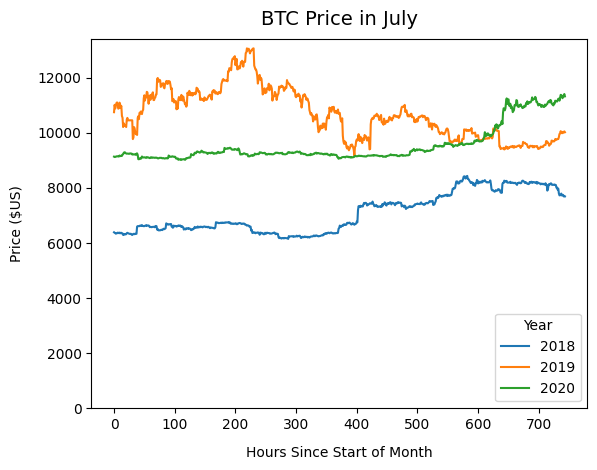

In [24]:
result = result.toPandas()

import matplotlib.pyplot as plt
plt.plot(list(zip(*result['openPrices'].tolist())))
plt.legend(result['year'], loc='lower right', title='Year')
plt.title("BTC Price in July", fontdict={'fontsize': 14}, pad=10)  # setting a title
plt.xlabel("Hours Since Start of Month", labelpad=10)  # setting an x-axis
plt.ylabel("Price ($US)", labelpad=10)  # setting a y-axis
plt.ylim(0, )
plt.show()

That's all for today's tutorial - enjoy your week! :)